In [1]:
from utils_data import load_data,scale_props,get_graphs
from utils_plotting import plot_property_histograms
from sklearn.model_selection import train_test_split
from utils_model import train_and_validate_multi,get_preds_per_task,vals_to_df
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import AttentiveFP
import torch
import pandas as pd

In [2]:
#with the changes to the code, calc the stats might not be going right, maybe use this instead:
def print_stats(ys,preds,prop):
    from sklearn.metrics import mean_squared_error, r2_score
    rmse = mean_squared_error(ys,preds,squared=False)
    r2_vp = r2_score(ys,preds)
    print('RMSE',prop,':',rmse)
    print('R2',prop,':',r2_vp)


def print_rmse_and_r2_unscaled(preds,ys):
    preds_vp = preds[0]
    preds_p = preds[1]
    ys_vp = ys[0]
    ys_p = ys[1]
    preds_vp =[p for p in preds_vp if p != -1]
    preds_p =[p for p in preds_p if p != -1]
    ys_vp =[p for p in ys_vp if p != -1]
    ys_p =[p for p in ys_p if p != -1]
    print_stats(ys_vp,preds_vp,'LogVP')
    print_stats(ys_p,preds_p,'LogP')


def print_rmse_and_r2_scaled(df_preds,df_ys):
    preds_vp = df_preds['LogVP'].dropna().values
    preds_p = df_preds['LogP'].dropna().values
    ys_vp = df_ys['LogVP'].dropna().values
    ys_p = df_ys['LogP'].dropna().values
    print_stats(ys_vp,preds_vp,'LogVP')
    print_stats(ys_p,preds_p,'LogP')

In [3]:
train = pd.read_csv("train.csv")
train_graphs_DASH_charge_scaled = get_graphs(train,dash_charges=True,scaled =True,save_graphs = True)

Loading previously created graphs


2594
RMSE LogVP : 1.2547386622703605
R2 LogVP : 0.8897130445541762
RMSE LogP : 0.7808277609124441
R2 LogP : 0.8242419753549977
None
-----------------------------------
Property: LogVP
kendall_tau: 0.8382406235228306
rmse_overall: 1.2547386622703605
mae_overall: 0.8229268321300994
within_03_overall: 0.2944038929440389
within_1_overall: 0.732360097323601
R2: 0.8897130445541762
Pearson: 0.9440506960240075


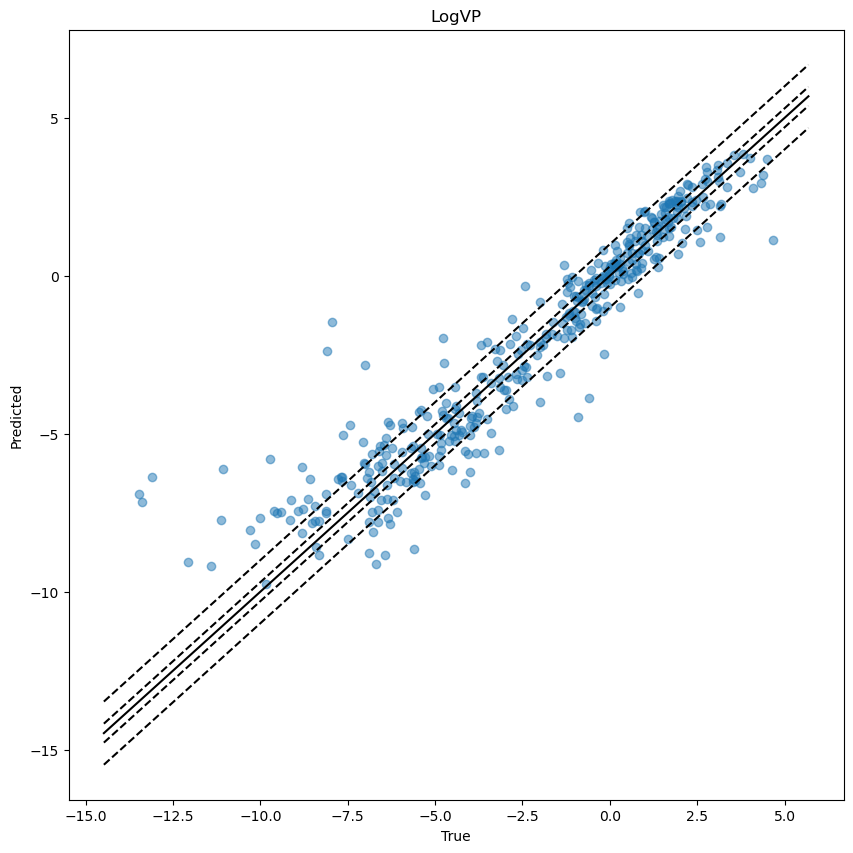

Property: LogP
kendall_tau: 0.7323411546886092
rmse_overall: 0.7808277609124441
mae_overall: 0.5719111754344558
within_03_overall: 0.36097114063215757
within_1_overall: 0.8460833715071003
R2: 0.8242419753549977
Pearson: 0.9082514844806888


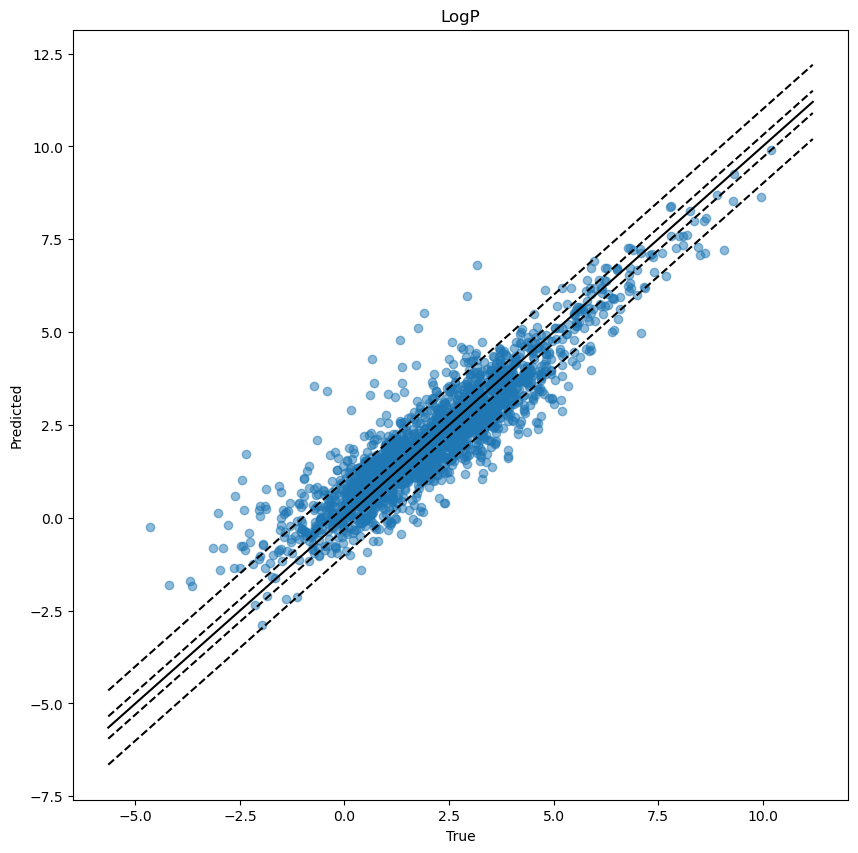

In [8]:
outputs = 14 #keep this at 14 for now, this is all the properties for which graphs are made
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data, val_data = train_test_split(train_graphs_DASH_charge_scaled, test_size=0.2, random_state=2000)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
model= AttentiveFP(in_channels=24, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
model.load_state_dict(torch.load('test_DASH_scaled_6props.pt'))
preds, ys = get_preds_per_task(model,val_loader, outputs,props_to_predict=['LogVP','LogP'])
df_preds = vals_to_df(preds,['LogVP','LogP'])
df_ys = vals_to_df(ys,['LogVP','LogP'])

#plot
from utils_plotting import plot_scatters
print(print_rmse_and_r2_scaled(df_preds,df_ys))
print('-----------------------------------')
plot_scatters(df_preds,df_ys)

In [14]:
#now freeze the hidden layers and train the output layer
model= AttentiveFP(in_channels=24, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
model.load_state_dict(torch.load('test_DASH_scaled_6props.pt'))
for name,param in model.named_parameters():
    if 'lin2' in name and name != 'gate_conv.lin2.weight':
        param.requires_grad = True
    else:
        param.requires_grad = False
#print out what needs grad
for name,param in model.named_parameters():
    if param.requires_grad:
        print(name,param.requires_grad)


lin2.weight True
lin2.bias True


In [26]:
#test with some props that seem to be related at first glance: HL, KOA,LogP, MP,BP,VP
train_graphs_DASH_charge_scaled = get_graphs(train,dash_charges=True,scaled =True,save_graphs = True)
props = ['LogHL','LogKOA','LogP','MP','BP','LogVP']
outputs = 14 #keep this at 14 for now, this is all the properties for which graphs are made
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data, val_data = train_test_split(train_graphs_DASH_charge_scaled, test_size=0.2, random_state=2000)
train_data_logp = [x for x in train_data if x.y[0][1] != -1]
val_data_logp = [x for x in val_data if x.y[0][1] != -1]

train_loader = DataLoader(train_data_logp, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data_logp, batch_size=64, shuffle=False)
model= AttentiveFP(in_channels=24, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
model.load_state_dict(torch.load('test_DASH_scaled_6props.pt'))
for name,param in model.named_parameters():
    if 'lin2' in name and name != 'gate_conv.lin2.weight':
        param.requires_grad = True
    else:
        param.requires_grad = False
#print out what needs grad
for name,param in model.named_parameters():
    if param.requires_grad:
        print(name,param.requires_grad)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-2,
                        weight_decay=10**-4)
print(len(train_data_logp), len(val_data_logp))
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=outputs, verbose=True,props_to_train=props,name='test_DASH_scaled_6props_postfreeze')

Loading previously created graphs
lin2.weight True
lin2.bias True
8872 2183
Epoch 1/100: Train Loss: 0.0524, Val Loss: 0.0554
Epoch 2/100: Train Loss: 0.0522, Val Loss: 0.0544
Epoch 3/100: Train Loss: 0.0526, Val Loss: 0.0539
Epoch 4/100: Train Loss: 0.0524, Val Loss: 0.0549
Epoch 5/100: Train Loss: 0.0521, Val Loss: 0.0542
Epoch 6/100: Train Loss: 0.0522, Val Loss: 0.0535
Epoch 7/100: Train Loss: 0.0520, Val Loss: 0.0541
Epoch 8/100: Train Loss: 0.0523, Val Loss: 0.0564
Epoch 9/100: Train Loss: 0.0522, Val Loss: 0.0588
Epoch 10/100: Train Loss: 0.0525, Val Loss: 0.0552


KeyboardInterrupt: 

In [29]:
#test with some props that seem to be related at first glance: HL, KOA,LogP, MP,BP,VP
train_graphs_DASH_charge_scaled = get_graphs(train,dash_charges=True,scaled =True,save_graphs = True)
props = ['LogHL','LogKOA','LogP','MP','BP','LogVP']
outputs = 14 #keep this at 14 for now, this is all the properties for which graphs are made
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data, val_data = train_test_split(train_graphs_DASH_charge_scaled, test_size=0.2, random_state=2000)
train_data_logp = [x for x in train_data if x.y[0][1] != -1]
val_data_logp = [x for x in val_data if x.y[0][1] != -1]

Loading previously created graphs


In [38]:
train_data_logp[1].y[0]

tensor([ 0.2711,  0.6836, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000,  0.5606, -1.0000])

In [76]:
tmp_tensor[1] = old_dat.y[0][1].item()

In [80]:
tmp_tensor = torch.tensor([-1]*14).view(14,1)
tmp_tensor[1]

tensor([-1])

4952
RMSE LogVP : 1.2727676466459437
R2 LogVP : 0.8865209106693087
RMSE LogP : 0.7856789930407588
R2 LogP : 0.822051244629278
None
-----------------------------------
Property: LogVP
kendall_tau: 0.8362464517146253
rmse_overall: 1.2727676466459437
mae_overall: 0.8470522330119451
within_03_overall: 0.26277372262773724
within_1_overall: 0.7347931873479319
R2: 0.8865209106693087
Pearson: 0.9415854336637075


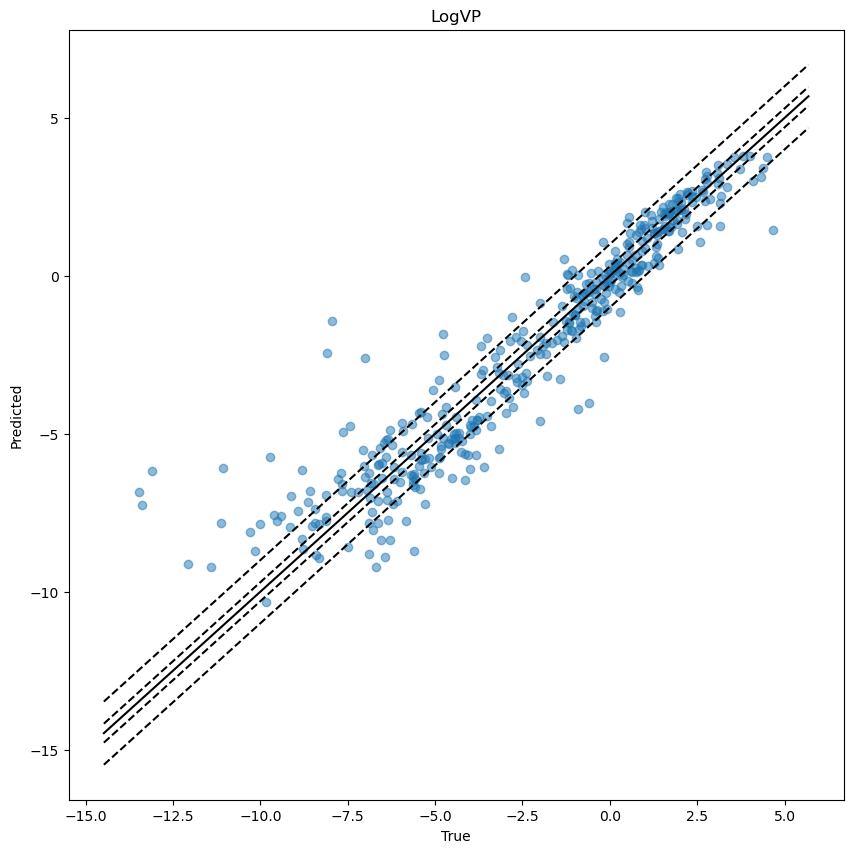

Property: LogP
kendall_tau: 0.7293651232750885
rmse_overall: 0.7856789930407588
mae_overall: 0.5775080223990057
within_03_overall: 0.36326156665139714
within_1_overall: 0.8382959230416858
R2: 0.822051244629278
Pearson: 0.9068988863759673


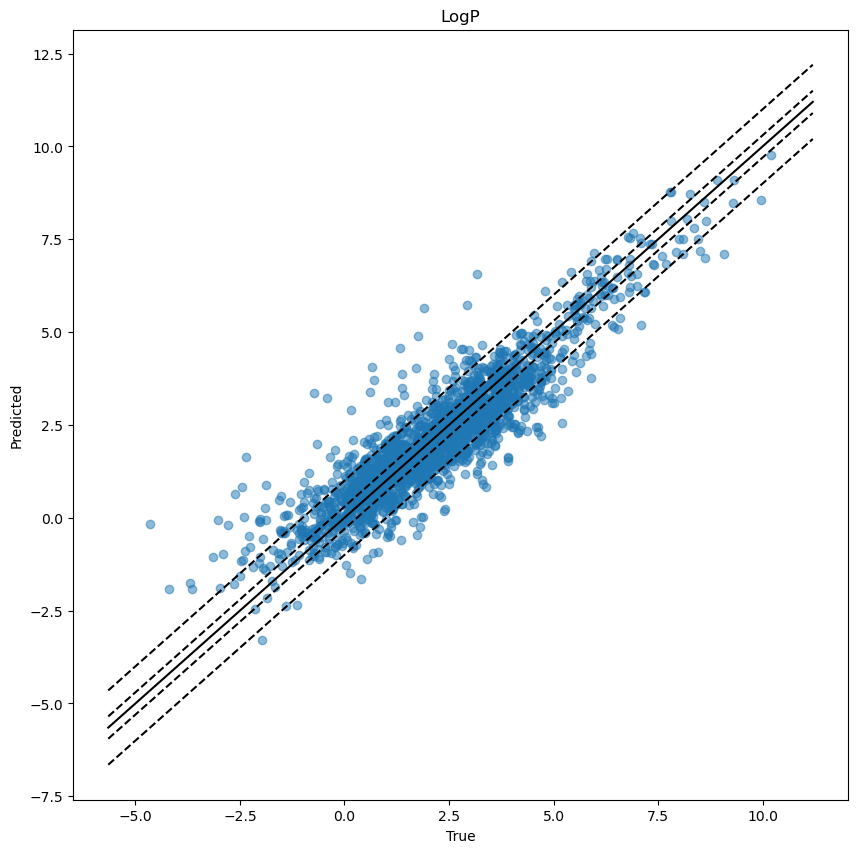

Property: BP
kendall_tau: 0.8225075888964646
rmse_overall: 29.205123613032537
mae_overall: 21.803611226896027
within_03_overall: 0.008433734939759036
within_1_overall: 0.024096385542168676
R2: 0.8889527008035717
Pearson: 0.9530024659023526


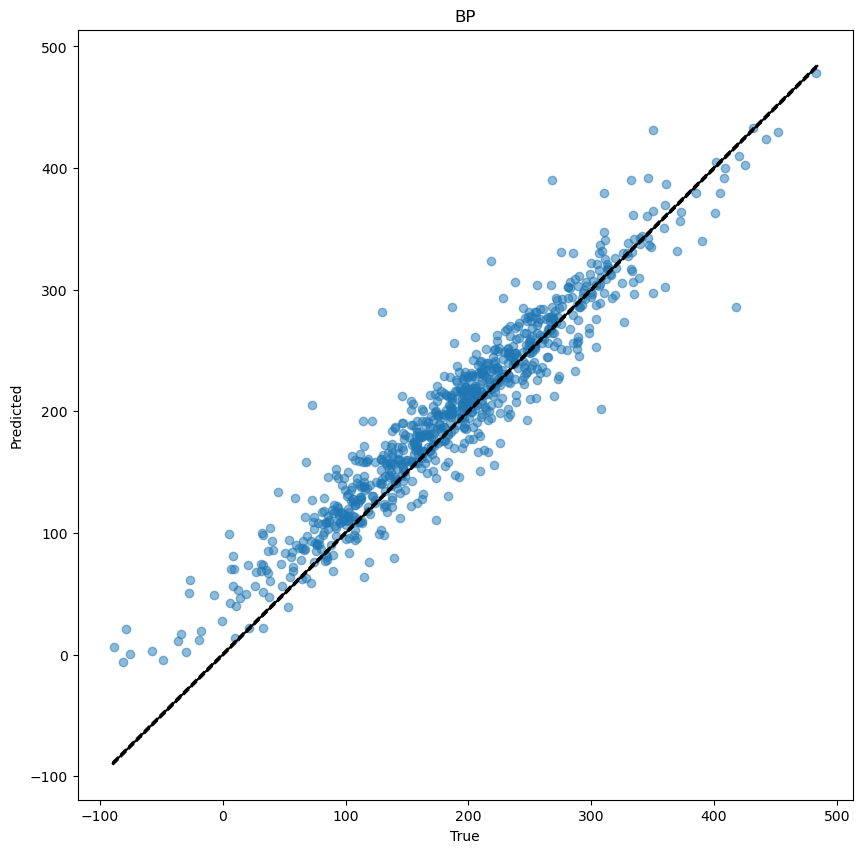

Property: LogHL
kendall_tau: 0.7095666463678819
rmse_overall: 1.0196921212849595
mae_overall: 0.7738868331996266
within_03_overall: 0.27927927927927926
within_1_overall: 0.6936936936936937
R2: 0.7748226110374061
Pearson: 0.8906485149027564


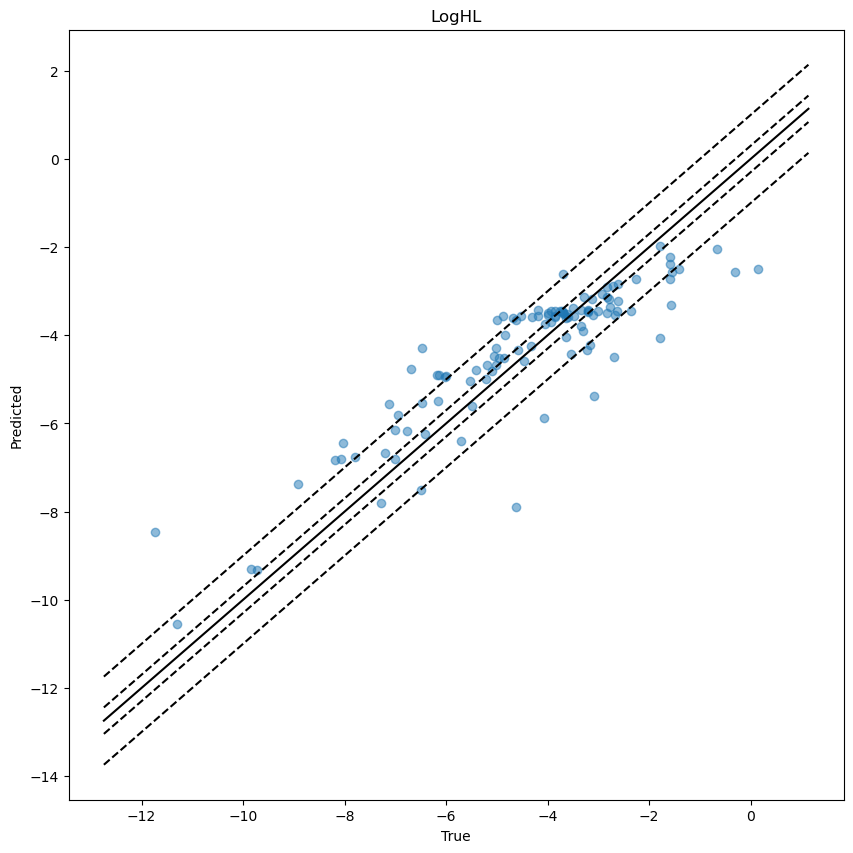

Property: LogKOA
kendall_tau: 0.8756302521008403
rmse_overall: 1.0502946564741058
mae_overall: 0.8928847592813628
within_03_overall: 0.17142857142857143
within_1_overall: 0.6571428571428571
R2: 0.8858794270200788
Pearson: 0.9851765866618583


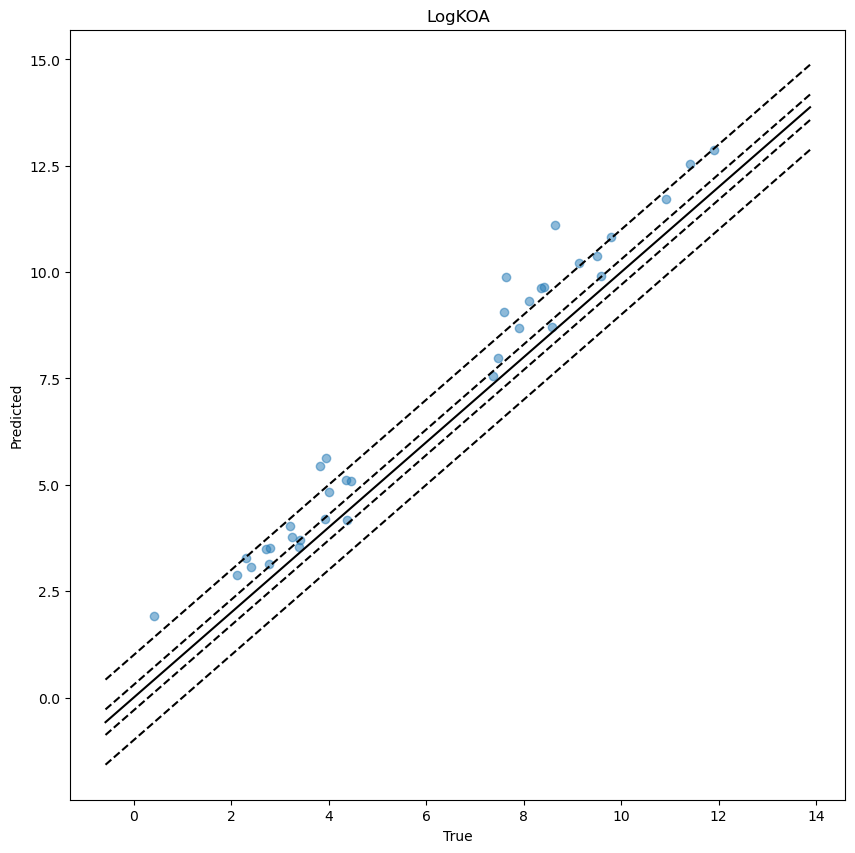

Property: MP
kendall_tau: 0.6910924371974901
rmse_overall: 50.1239154507813
mae_overall: 38.02423814267551
within_03_overall: 0.008683068017366137
within_1_overall: 0.015195369030390739
R2: 0.7515575846225812
Pearson: 0.868477984903415


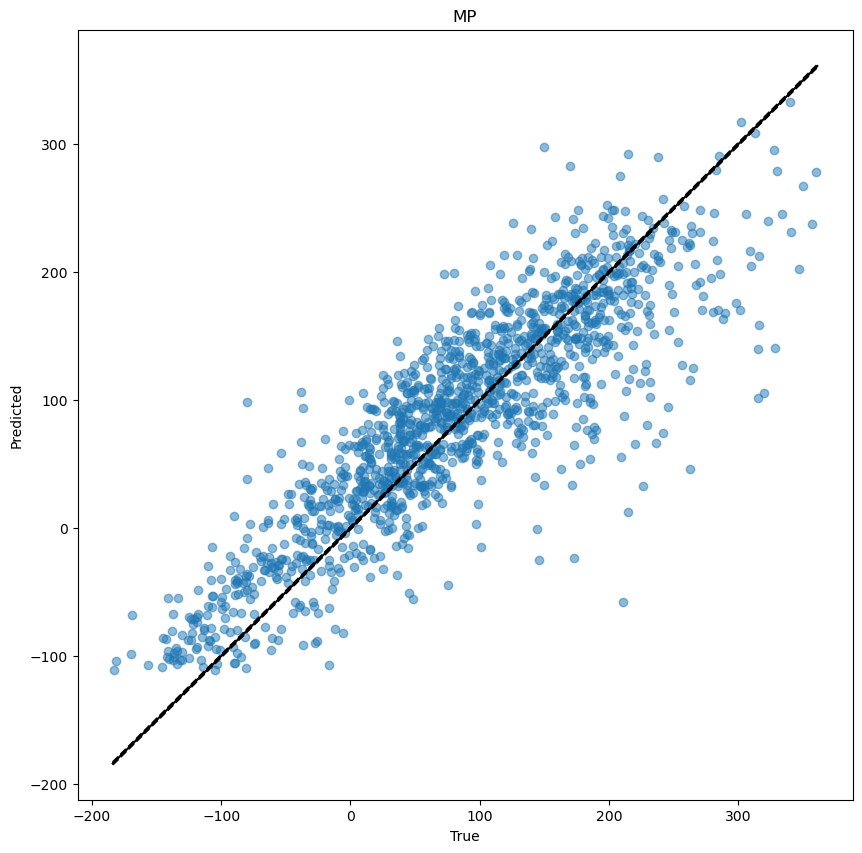

In [19]:
model.load_state_dict(torch.load('test_DASH_scaled_6props_postfreeze.pt'))
preds, ys = get_preds_per_task(model,val_loader, outputs,props_to_predict=props)
df_preds = vals_to_df(preds,props)
df_ys = vals_to_df(ys,props)
#plot
from utils_plotting import plot_scatters
print(print_rmse_and_r2_scaled(df_preds,df_ys))
print('-----------------------------------')
plot_scatters(df_preds,df_ys)